### Notebook for initializing polymer systems using a combined DPD + WCA potential

In [85]:
import matplotlib
import numpy as np  
import scipy.stats
import gsd, gsd.hoomd 
import freud 
import math
import itertools 
import hoomd 
import fresnel 
%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
def render(frame):
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = np.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        bond_distances = np.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = np.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
                
    return fresnel.preview(scene)

In [86]:
def initialize_snapshot(num_pol, num_mon, density=0.85):
    N = num_pol * num_mon
    L = np.cbrt(N / density)  # Calculate box size based on density
    positions = np.random.uniform(low=-L/2, high=L/2, size=(N, 3))
    bonds = []
    for i in range(num_pol):
        start = i * num_mon
        for j in range(num_mon - 1):
            bonds.append([start + j, start + j + 1])
    bonds = np.array(bonds)
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['A']
    frame.particles.N = N
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    frame.configuration.box = [L, L, L, 0, 0, 0]
    return frame

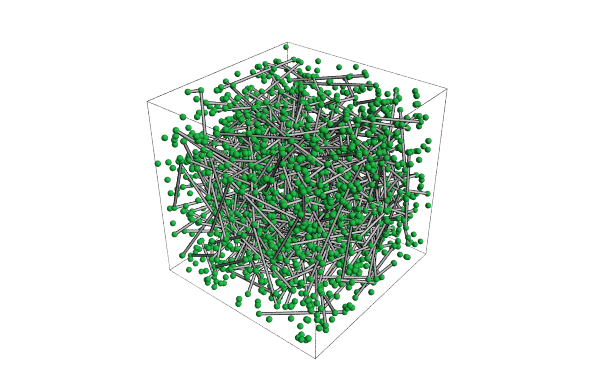

In [87]:
test = initialize_snapshot(10,200)
render(test)

#### Assign a harmonic bond potential to the bonds between particles

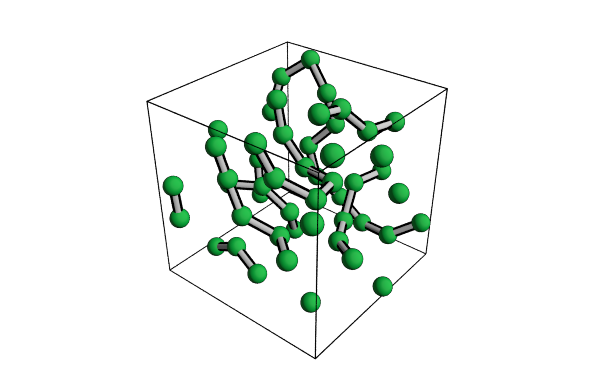

In [93]:
num_pol = 1
num_mon = 50
kT = 0.2
l = 1.0
timestep = 0.01
gamma = 0.05
A = 100.0

frame = initialize_snapshot(num_pol, num_mon, density=0.85)

harmonic = hoomd.md.bond.Harmonic()
harmonic.params["b"] = dict(r0=l, k=100)

integrator = hoomd.md.Integrator(dt=timestep)
integrator.forces.append(harmonic)

simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=12)
simulation.operations.integrator = integrator 
simulation.create_state_from_snapshot(frame)

const_vol = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(const_vol)

nlist = hoomd.md.nlist.Cell(buffer=0.4)
simulation.operations.nlist = nlist
DPD = hoomd.md.pair.DPD(nlist, default_r_cut=cut, kT=kT)
DPD.params[('A', 'A')] = dict(A=A, gamma=gamma)
integrator.forces.append(DPD)
simulation.operations.integrator = integrator

gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10_000), 
    mode='wb',
    dynamic=['property','momentum'],
    filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol),
    truncate=False)
simulation.operations.writers.append(gsd_out)
simulation.run(1_000)
gsd_out.flush()
while(longbond('run_len_%s_pol_%s.gsd'%(num_mon,num_pol))>maxBond  ) :
    simulation.run(1_000)
    gsd_out.flush()
render(simulation.state.get_snapshot())

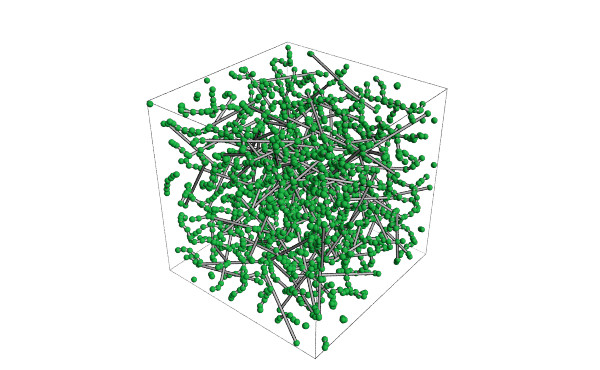

In [ ]:
#Snapshot from back when things didn't work. 

### Compute the bond length relaxation

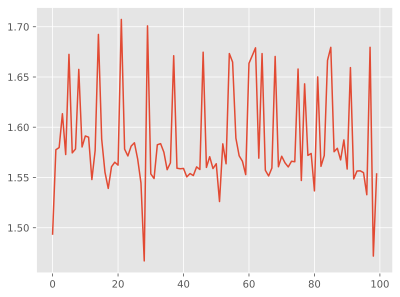

In [91]:
import matplotlib.pyplot as plt

with gsd.hoomd.open('run_len_%s_pol_%s.gsd'%(num_mon,num_pol),'r') as traj:
    avg_frame_bond_l = []
    for frame in traj:
        bond_l = []
        for i in range(0,num_mon-2):
            dr = np.linalg.norm((frame.particles.position[i+1] - frame.particles.position[i]), axis=0)
            bond_l.append(dr)
        avg_frame_bond_l.append(np.mean(bond_l))

plt.plot(avg_frame_bond_l)

#### Switching to WCA/LJ potential

* Run the above minimization until all bonds are less than FENE bond length
* Use that as automated criteria for determining convergence
* Once all bonds are reasonable, turn on WCA via linear ramp of lambda
* May not need linear ramp, but should still test (thermodynamic integration)


In [101]:
import hoomd.azplugins

perturbed_lj = hoomd.azplugins.pair.PerturbedLennardJones(
    default_r_cut=3.0, nlist=nlist)
perturbed_lj.params[('A', 'A')] = dict(
    epsilon=1.0, sigma=1.0, attraction_scale_factor=0.5)
perturbed_lj.r_cut[('A', 'B')] = 3.0

ModuleNotFoundError: No module named 'hoomd.azplugins'

In [100]:
# You can easily remove the DPD potential and use a WCA/LJ potential instead.
#integrator.forces.pop()

# Switch to the WCA potential

fenewca = hoomd.md.bond.FENEWCA()
fenewca.params["A"] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)
integrator.forces.append(fenewca)

nl = hoomd.md.nlist.Tree(buffer=1.0, exclusions=["bond"])
wca = hoomd.md.pair.LJ(nlist=nl, default_r_cut=2.0 ** (1.0 / 6.0), mode="shift")
wca.params[("A", "A")] = dict(sigma=1.0, epsilon=1.0)
integrator.forces.append(wca)

IncompleteSpecificationError: Error applying parameters for object of type <class 'hoomd.md.bond.FENEWCA'>.